# Import Required Libraries

In [1]:
WANDB = True
EXP_NAME = "val3-3_swin_small_inc-pos60"
# EXP_NAME = "try"

if WANDB:
    # !pip install wandb
    import wandb
    import os
    from dotenv import load_dotenv
    load_dotenv()
    wandb.login(key=os.environ.get("WANDB_API_KEY"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trira7503. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
# from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Training Configuration

In [3]:
CONFIG = {
    "seed": 42,
    "epochs": 30,
    # "epochs": 3, #######　後でなおすこと
    "img_size": 224,
    "model_name": "swin_small_patch4_window7_224",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 64,
    "valid_batch_size": 128,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-9,
#     "T_max": 10316,
    "weight_decay": 1e-5,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "use_tta": False,
    "mixup_alpha": 0.4,  # 既存のMixupのパラメータ
    "mixup_epochs": 22,  # Mixupを適用するエポック数を追加
    "dropout_rate": 0.2,
    "warmup_steps": 60,  # Warmupのステップ数を追加
    "warmup_factor": 0.02,  # 初期学習率の倍率
    "save_preds": True,
    "save_dir": "../proc/preds",
    "save_model": True,
    "save_model_dir": f"../proc/models/{EXP_NAME}",
}

In [4]:
if CONFIG["save_model"]:
    if not os.path.exists(CONFIG["save_model_dir"]):
        os.mkdir(CONFIG["save_model_dir"])

# Set Seed for Reproducibility

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [6]:
ROOT_DIR = "../raw"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [7]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# Read the Data

In [8]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [9]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
print(df.shape)
df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

(401059, 55)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,../raw/train-image/image/ISIC_0015670.jpg
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,../raw/train-image/image/ISIC_0015845.jpg
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,../raw/train-image/image/ISIC_0015864.jpg
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,../raw/train-image/image/ISIC_0015902.jpg
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,../raw/train-image/image/ISIC_0024200.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,../raw/train-image/image/ISIC_9999937.jpg
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,../raw/train-image/image/ISIC_9999951.jpg
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,../raw/train-image/image/ISIC_9999960.jpg
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,../raw/train-image/image/ISIC_9999964.jpg


In [10]:
df_patient = df.groupby("patient_id")[["isic_id"]].agg(
    count_per_patient=("isic_id", "count"), 
).sort_values(by="count_per_patient").reset_index()
df_patient.head(2)

,patient_id,count_per_patient
0,IP_5792391,1
1,IP_1487179,1


In [11]:
df = df.merge(df_patient, on="patient_id", how="left")
df.shape[0], df.target.sum()

(401059, 393)

In [12]:
df.shape[0], df.target.sum()

(401059, 393)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [13]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=0)

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)
        
# df[["isic_id", "kfold"]].to_csv("df_fold.csv", index=False)
df[["isic_id", "kfold"]]

,isic_id,kfold
0,ISIC_0015670,4.0
1,ISIC_0015845,2.0
2,ISIC_0015864,1.0
3,ISIC_0015902,2.0
4,ISIC_0024200,1.0
...,...,...
401054,ISIC_9999937,1.0
401055,ISIC_9999951,3.0
401056,ISIC_9999960,0.0
401057,ISIC_9999964,2.0


In [14]:
print(df["target"].sum())
cols_pos = [
    'ISIC_5518264',
 'ISIC_2008771',
 'ISIC_0107943',
 'ISIC_3400253',
 'ISIC_6468722',
 'ISIC_0940056',
 'ISIC_8626891',
 'ISIC_2122753',
 'ISIC_4173597',
 'ISIC_5219286',
 'ISIC_4087330',
 'ISIC_8849663',
 'ISIC_0173889',
 'ISIC_9203388',
 'ISIC_6507009',
 'ISIC_7590216',
 'ISIC_7032512',
 'ISIC_7561558',
 'ISIC_7257077',
 'ISIC_8481333',
 'ISIC_0718349',
 'ISIC_7073762',
 'ISIC_4559359',
 'ISIC_1879424',
 'ISIC_6402332',
 'ISIC_4966073',
 'ISIC_7453281',
 'ISIC_8176994',
 'ISIC_1753955',
 'ISIC_7406213',
 'ISIC_5885005',
 'ISIC_3506622',
 'ISIC_4180089',
 'ISIC_6058837',
 'ISIC_8503864',
 'ISIC_7681571',
 'ISIC_3678352',
 'ISIC_2716711',
 'ISIC_1795825',
 'ISIC_1636324',
 'ISIC_4646711',
 'ISIC_9204220',
 'ISIC_3001826',
 'ISIC_5076339',
 'ISIC_8848664',
 'ISIC_5473320',
 'ISIC_6493854',
 'ISIC_1660400',
 'ISIC_3666671',
 'ISIC_7957078',
 'ISIC_4264734',
 'ISIC_6773249',
 'ISIC_6674016',
 'ISIC_3541321',
 'ISIC_7488074',
 'ISIC_7269914',
 'ISIC_6473498',
 'ISIC_0811645',
 'ISIC_0609440',
 'ISIC_5401839',
 'ISIC_6782197',
 'ISIC_3902575',
 'ISIC_7086834',
 'ISIC_7050655',
 'ISIC_0472484',
 'ISIC_9689059',
 'ISIC_7801895',
 'ISIC_2085558',
 'ISIC_1828316',
 'ISIC_6240034',
 'ISIC_9146872',
 'ISIC_5361150',
 'ISIC_7436637',
 'ISIC_1948223',
 'ISIC_0932118',
 'ISIC_8277996',
 'ISIC_8939581',
 'ISIC_0967190',
 'ISIC_2221374',
 'ISIC_6931419',
 'ISIC_5678980',
 'ISIC_6348374',
 'ISIC_8696844',
 'ISIC_9368520',
 'ISIC_6087072',
 'ISIC_5940288',
 'ISIC_4616252',
 'ISIC_8820942',
 'ISIC_5056174',
 'ISIC_8996327',
 'ISIC_5574285',
 'ISIC_3418189',
 'ISIC_8516842',
 'ISIC_5734453',
 'ISIC_5444768',
 'ISIC_4944542',
 'ISIC_8688899',
 'ISIC_3530806',
 'ISIC_4224542',
 'ISIC_9720183',
 'ISIC_8945277',
 'ISIC_2475745',
 'ISIC_7360867',
 'ISIC_4420538',
 'ISIC_0666842',
 'ISIC_6441955',
 'ISIC_0582631',
 'ISIC_4353025',
 'ISIC_5143533',
 'ISIC_8292121',
 'ISIC_4700313',
 'ISIC_6894830',
 'ISIC_3439605',
 'ISIC_5022051',
 'ISIC_7931359',
 'ISIC_1070164',
 'ISIC_6959619',
 'ISIC_4556564',
 'ISIC_3505855',
 'ISIC_5985734',
 'ISIC_7114844',
 'ISIC_1459374',
 'ISIC_1752095',
 'ISIC_8797926',
 'ISIC_5301714',
 'ISIC_4629715',
 'ISIC_2972523',
 'ISIC_6163825',
 'ISIC_3976425',
 'ISIC_7611479',
 'ISIC_2871853',
 'ISIC_6800695',
 'ISIC_9081793',
 'ISIC_2933421',
 'ISIC_8695576',
 'ISIC_0704755',
 'ISIC_3815659',
 'ISIC_9834289',
 'ISIC_0377274',
 'ISIC_4526825',
 'ISIC_8297496',
 'ISIC_5456926',
 'ISIC_2444245',
 'ISIC_6346300',
 'ISIC_4478794',
 'ISIC_4581581',
 'ISIC_6913761',
 'ISIC_3420650',
 'ISIC_8659663',
 'ISIC_9783183',
 'ISIC_1967528',
 'ISIC_9015553',
 'ISIC_1825785',
 'ISIC_9873073',
 'ISIC_3408909',
 'ISIC_2194880',
 'ISIC_4563936',
 'ISIC_9758154',
 'ISIC_9325482',
 'ISIC_5033087',
 'ISIC_8067982',
 'ISIC_7118037',
 'ISIC_7976099',
 'ISIC_6827350',
 'ISIC_9880444',
 'ISIC_8988293',
 'ISIC_7948199',
 'ISIC_7861792',
 'ISIC_2400763',
 'ISIC_5778946',
 'ISIC_8408140',
 'ISIC_0179858',
 'ISIC_1494758',
 'ISIC_4516887',
 'ISIC_0989971',
 'ISIC_9999107',
 'ISIC_7175907',
 'ISIC_8296962',
 'ISIC_8831395',
 'ISIC_4892145',
 'ISIC_6658007',
 'ISIC_4597546',
 'ISIC_3427672',
 'ISIC_5896728',
 'ISIC_2510305',
 'ISIC_4465292',
 'ISIC_9923515',
 'ISIC_8744037',
 'ISIC_5756321',
 'ISIC_5820851',
 'ISIC_4685649',
 'ISIC_7686886',
 'ISIC_2624879',
 'ISIC_1215450',
 'ISIC_1110208',
 'ISIC_3327285',
 'ISIC_8013573',
 'ISIC_9034396',
 'ISIC_2174953',
 'ISIC_2938080',
 'ISIC_1504781',
 'ISIC_7009513',
 'ISIC_0493373',
 'ISIC_1764886',
 'ISIC_1464154',
 'ISIC_0392047',
 'ISIC_3086424',
 'ISIC_1535063',
 'ISIC_3388796',
 'ISIC_8031362',
 'ISIC_2036691',
 'ISIC_8290600',
 'ISIC_7208251',
 'ISIC_3539750',
 'ISIC_2920305',
 'ISIC_5061228',
 'ISIC_4905269',
 'ISIC_6678031',
 'ISIC_7343022',
 'ISIC_7769815',
 'ISIC_8630375',
 'ISIC_5209592',
 'ISIC_0188892',
 'ISIC_7795931',
 'ISIC_2563069',
 'ISIC_4026281',
 'ISIC_9439522',
 'ISIC_2634375',
 'ISIC_3860571',
 'ISIC_3165525',
 'ISIC_9027229',
 'ISIC_7584794',
 'ISIC_4433275',
 'ISIC_3426558',
 'ISIC_0510301',
 'ISIC_3616556',
 'ISIC_8313731',
 'ISIC_6123647',
 'ISIC_8145520',
 'ISIC_2108101',
 'ISIC_1976646',
 'ISIC_1483099',
 'ISIC_1862557',
 'ISIC_7058606',
 'ISIC_6618102',
 'ISIC_8612102',
 'ISIC_9246981',
 'ISIC_9828567',
 'ISIC_2116022',
 'ISIC_4259356',
 'ISIC_4322900',
 'ISIC_0584682',
 'ISIC_8230285',
 'ISIC_0432088',
 'ISIC_1411822',
 'ISIC_0824663',
 'ISIC_2347724',
 'ISIC_7922458',
 'ISIC_9664961',
 'ISIC_2516455',
 'ISIC_9389521',
 'ISIC_1262019',
 'ISIC_1862475',
 'ISIC_8167488',
 'ISIC_4126899',
 'ISIC_8979666',
 'ISIC_7992260',
 'ISIC_2865725',
 'ISIC_1583457',
 'ISIC_9066911',
 'ISIC_2295901',
 'ISIC_4187658',
 'ISIC_9195989',
 'ISIC_6563912',
 'ISIC_0809631',
 'ISIC_2470540',
 'ISIC_4932158',
 'ISIC_5353496',
 'ISIC_1471931',
 'ISIC_7806351',
 'ISIC_4741592',
 'ISIC_2325276',
 'ISIC_0958178',
 'ISIC_9145048',
 'ISIC_0807301',
 'ISIC_7817366',
 'ISIC_0246502',
 'ISIC_7800626',
 'ISIC_4242510',
 'ISIC_1753361',
 'ISIC_4544598',
 'ISIC_0596122',
 'ISIC_3301600',
 'ISIC_2175101',
 'ISIC_6621666',
 'ISIC_1334224',
 'ISIC_6060936',
 'ISIC_9001660',
 'ISIC_3274695',
 'ISIC_8125339'
]

df["target_original"] = df["target"]
df.loc[df["isic_id"].isin(cols_pos), "target"] = 1
print(df["target"].sum())

393
693


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [15]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [16]:
# Mixupを行う関数を追加
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Batch size should be larger than 1"

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [17]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [18]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        # xの次元数が4（バッチ、チャネル、高さ、幅）であることを確認
        if x.dim() != 4:
            raise ValueError(f'Expected 4D input (got {x.dim()}D input)')
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [19]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None, dropout_rate=CONFIG['dropout_rate']):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

        # モデルの出力サイズを取得
        if hasattr(self.model, 'num_features'):
            in_features = self.model.num_features  # num_featuresで取得するモデルが多い
        elif hasattr(self.model, 'classifier') and hasattr(self.model.classifier, 'in_features'):
            in_features = self.model.classifier.in_features  # classifierが存在する場合
        elif hasattr(self.model, 'fc') and hasattr(self.model.fc, 'in_features'):
            in_features = self.model.fc.in_features  # fcが存在する場合
        else:
            raise AttributeError("Could not find the output feature size.")

        # モデルのヘッド部分をIdentityで置き換え
        self.model.reset_classifier(0)  # timmで全結合層をリセットする簡単な方法

        # 以下のノートブックを参照した
        # https://www.kaggle.com/code/qiaoyingzhang/isic-2024-pytorch-training-baseline-swin#Modeling

        # Final fully connected layer for classification
        self.final_fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, images):
        features = self.model(images)  # ここを変更
        output = self.final_fc(features)
        return output


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [20]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)
#     return nn.CrossEntropyLoss()(outputs, targets) 

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [21]:
def comp_score_list(solution: list, submission: list, min_tpr: float=0.80):
    v_gt = np.abs(np.array(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [22]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # Mixupを設定されたエポック数まで適用
        if epoch <= CONFIG['mixup_epochs']:
            mixed_images, targets_a, targets_b, lam = mixup(images, targets, alpha=CONFIG['mixup_alpha'])
            outputs = model(mixed_images).squeeze()
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [23]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    # TTAのためのカウンター
    tta_counter = 0
    
    # TTAのための関数を定義
    def apply_tta(model, image):
        outputs = []
        
        # オリジナル画像
        outputs.append(model(image).squeeze())
        
        # 水平フリップ
        outputs.append(model(torch.flip(image, dims=[3])).squeeze())
        
        # 垂直フリップ
        outputs.append(model(torch.flip(image, dims=[2])).squeeze())
        
        # 90度、180度、270度回転
        for k in [1, 2, 3]:
            outputs.append(model(torch.rot90(image, k, dims=[2,3])).squeeze())
        
        return torch.stack(outputs).mean(dim=0)
    
    all_outputs = []
    all_targets = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        if CONFIG['use_tta']:
            outputs = apply_tta(model, images).squeeze()
        else:
            outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        all_outputs.extend(outputs.detach().cpu().numpy().flatten())  # 確率に変換して蓄積
        all_targets.extend(targets.detach().cpu().numpy().flatten())  # ラベルを蓄積

#         auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, 
                        LR=optimizer.param_groups[0]['lr'])   
    
    # epoch毎にauroc算出
    epoch_auroc = comp_score_list(all_targets, all_outputs)
    
    gc.collect()
    
    return epoch_loss, epoch_auroc, all_outputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [24]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    save_dir = CONFIG["save_model_dir"]
    df_best_pred = df.loc[df["kfold"]==fold, ["isic_id", "target"]]
    PATH_BEST = None
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, outputs_np = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=epoch
        )
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append(scheduler.get_last_lr()[0])
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc:.5f} ---> {val_epoch_auroc:.5f})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            if epoch > CONFIG['mixup_epochs']:
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH_BEST = "{}/pAUC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG["save_model_dir"], val_epoch_auroc, val_epoch_loss, epoch)

        else:
            print(f"Validation pAUC80 not Improved ({val_epoch_auroc:.5f})")

        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # ベストのモデルを保存する
    # if PATH_BEST is not None:
    #     torch.save(best_model_wts, PATH_BEST)
    
    # 最後のモデルを保存する
    PATH = "{}/pAUC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG["save_model_dir"], val_epoch_auroc, val_epoch_loss, epoch)
    torch.save(model.state_dict(), PATH)
    
    return model, history

In [25]:
class WarmupScheduler:
    def __init__(self, optimizer, warmup_steps, warmup_factor, base_scheduler):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.warmup_factor = warmup_factor
        self.base_scheduler = base_scheduler
        self.current_step = 0

    def step(self):
        self.current_step += 1
        if self.current_step < self.warmup_steps:
            lr_scale = self.warmup_factor + (1 - self.warmup_factor) * (self.current_step / self.warmup_steps)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr_scale * param_group['initial_lr']
        else:
            self.base_scheduler.step()

    def get_last_lr(self):
        if self.current_step < self.warmup_steps:
            lr_scale = self.warmup_factor + (1 - self.warmup_factor) * (self.current_step / self.warmup_steps)
            return [lr_scale * param_group['initial_lr'] for param_group in self.optimizer.param_groups]
        else:
            return self.base_scheduler.get_last_lr()

def fetch_scheduler(optimizer, T_max=None):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        base_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        base_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG['T_0'], eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    return WarmupScheduler(optimizer, CONFIG['warmup_steps'], CONFIG['warmup_factor'], base_scheduler)


In [26]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

# CV

In [27]:
# wandbの初期化
if WANDB:
    wandb_config = {
        # ... 既存の設定 ...
        "epochs": CONFIG['epochs'],
        "learning_rate": CONFIG['learning_rate'],
        "min_lr": CONFIG["min_lr"],
        "weight_decay": CONFIG["weight_decay"],
        "mixup_alpha": CONFIG["mixup_alpha"],
        "mixup_epochs": CONFIG["mixup_epochs"],  # 新しく追加
    }
    wandb.init(project="ISIC2024_images", name=EXP_NAME, config=wandb_config)

In [28]:
list_score_notFiltered = []
list_preds = []
for fold in range(CONFIG["n_fold"]):
    print("==="*10)
    print(f"fold {fold}")
    print("==="*10)
    
    df_train = df[df["kfold"]!=fold]
    df_val = df[df["kfold"]==fold]
    df_val["target"] = df_val["target_original"]

    # trainのダウンサンプリング
    print("●train")
    print("original>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    df_positive = df_train[df_train["target"] == 1].reset_index(drop=True)
    df_negative = df_train[df_train["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_train = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    
    # valのダウンサンプリング
    print("●val")
    print("original>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    df_positive = df_val[df_val["target"] == 1].reset_index(drop=True)
    df_negative = df_val[df_val["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_val = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    
    # いったん全データ結合
    df_fold = pd.concat((df_train, df_val)).reset_index(drop=True)
    del df_train, df_val
    
    model = ISICModel(CONFIG['model_name'], pretrained=True)
    model.to(CONFIG['device']);
    
    # 最後のfoldだけ勾配を記録する うまく行ってるのかよくわからん
#     if fold==4 and WANDB:
#         wandb.watch(model, log="all", log_freq=1)
    
    train_loader, valid_loader = prepare_loaders(df_fold, fold=fold)
    # optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
    #                         weight_decay=CONFIG['weight_decay'])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    T_max = len(train_loader) * CONFIG["epochs"] - CONFIG["warmup_steps"]
    scheduler = fetch_scheduler(optimizer, T_max=T_max)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    history = pd.DataFrame.from_dict(history)
    history.to_csv(f"{CONFIG['save_dir']}/history_fold{fold}.csv", index=False)

    #########################
    # valの全データでスコア確認
    #########################
    df_val = df[df["kfold"]==fold]
    df_val["target"] = df_val["target_original"]
    df_val_pred = df_val[["isic_id", "kfold", "target"]]
    
    valid_dataset = ISICDataset(df_val, transforms=data_transforms["valid"])
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    preds = []
    with torch.no_grad():
        bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, data in bar:        
            images = data['image'].to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            outputs = model(images).squeeze()
            preds.extend(outputs.detach().cpu().numpy().flatten())
    
    df_val_pred["preds"] = preds
    list_preds.append(df_val_pred)

    # マルチクラス用のpAUC計算
    epoch_pauc = comp_score_list(df_val["target"].to_list(), preds)
    print(f"fold{fold}_pAUC (not filtered): {epoch_pauc:.4f}")
    list_score_notFiltered.append(epoch_pauc)
    
    # 不要なメモリを開放
    del model, optimizer, scheduler, train_loader, valid_loader, history
    torch.cuda.empty_cache()

fold 0
●train
original> (306580, 59) 560 (835,)
filtered> (11760, 59) 560 (792,)
●val
original> (94479, 59) 73 (207,)
filtered> (1533, 59) 73 (180,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:02<00:00,  4.52it/s, Epoch=1, LR=1.49e-5, Valid_Loss=0.555]


Validation AUROC Improved (-inf ---> 0.04529)



100%|██████████| 12/12 [00:02<00:00,  5.21it/s, Epoch=2, LR=2.88e-5, Valid_Loss=0.32] 


Validation AUROC Improved (0.04529 ---> 0.07218)



100%|██████████| 12/12 [00:02<00:00,  5.28it/s, Epoch=3, LR=4.26e-5, Valid_Loss=0.4]  


Validation AUROC Improved (0.07218 ---> 0.09419)



100%|██████████| 12/12 [00:02<00:00,  5.26it/s, Epoch=4, LR=4.91e-5, Valid_Loss=0.397]


Validation AUROC Improved (0.09419 ---> 0.11687)



100%|██████████| 12/12 [00:02<00:00,  5.29it/s, Epoch=5, LR=4.88e-5, Valid_Loss=0.167]


Validation AUROC Improved (0.11687 ---> 0.12236)



100%|██████████| 12/12 [00:02<00:00,  5.19it/s, Epoch=6, LR=4.81e-5, Valid_Loss=0.406]


Validation AUROC Improved (0.12236 ---> 0.13464)



100%|██████████| 12/12 [00:02<00:00,  5.23it/s, Epoch=7, LR=4.71e-5, Valid_Loss=0.283]


Validation AUROC Improved (0.13464 ---> 0.14119)



100%|██████████| 12/12 [00:02<00:00,  5.12it/s, Epoch=8, LR=4.57e-5, Valid_Loss=0.14] 


Validation pAUC80 not Improved (0.13528)



100%|██████████| 12/12 [00:02<00:00,  5.18it/s, Epoch=9, LR=4.41e-5, Valid_Loss=0.281]


Validation pAUC80 not Improved (0.13752)



100%|██████████| 12/12 [00:02<00:00,  5.15it/s, Epoch=10, LR=4.22e-5, Valid_Loss=0.211]


Validation AUROC Improved (0.14119 ---> 0.14623)



100%|██████████| 12/12 [00:02<00:00,  5.16it/s, Epoch=11, LR=4e-5, Valid_Loss=0.165]


Validation pAUC80 not Improved (0.14274)



100%|██████████| 12/12 [00:02<00:00,  5.08it/s, Epoch=12, LR=3.76e-5, Valid_Loss=0.326]


Validation pAUC80 not Improved (0.13587)



100%|██████████| 12/12 [00:02<00:00,  5.24it/s, Epoch=13, LR=3.51e-5, Valid_Loss=0.2]  


Validation pAUC80 not Improved (0.12938)



100%|██████████| 12/12 [00:02<00:00,  5.15it/s, Epoch=14, LR=3.24e-5, Valid_Loss=0.198]


Validation pAUC80 not Improved (0.14291)



100%|██████████| 12/12 [00:02<00:00,  5.10it/s, Epoch=15, LR=2.95e-5, Valid_Loss=0.242]


Validation pAUC80 not Improved (0.14188)



100%|██████████| 12/12 [00:02<00:00,  5.20it/s, Epoch=16, LR=2.67e-5, Valid_Loss=0.208]


Validation pAUC80 not Improved (0.14420)



100%|██████████| 12/12 [00:02<00:00,  5.09it/s, Epoch=17, LR=2.37e-5, Valid_Loss=0.158]


Validation pAUC80 not Improved (0.14041)



100%|██████████| 12/12 [00:02<00:00,  5.26it/s, Epoch=18, LR=2.08e-5, Valid_Loss=0.293]


Validation pAUC80 not Improved (0.14395)



100%|██████████| 12/12 [00:02<00:00,  5.18it/s, Epoch=19, LR=1.8e-5, Valid_Loss=0.182]


Validation pAUC80 not Improved (0.14089)



100%|██████████| 12/12 [00:02<00:00,  5.24it/s, Epoch=20, LR=1.52e-5, Valid_Loss=0.201]


Validation pAUC80 not Improved (0.14107)



100%|██████████| 12/12 [00:02<00:00,  5.16it/s, Epoch=21, LR=1.26e-5, Valid_Loss=0.198]


Validation pAUC80 not Improved (0.14400)



100%|██████████| 12/12 [00:02<00:00,  5.17it/s, Epoch=22, LR=1.01e-5, Valid_Loss=0.194]


Validation pAUC80 not Improved (0.14467)



100%|██████████| 12/12 [00:02<00:00,  5.22it/s, Epoch=23, LR=7.89e-6, Valid_Loss=0.169]


Validation AUROC Improved (0.14623 ---> 0.14748)



100%|██████████| 12/12 [00:02<00:00,  5.17it/s, Epoch=24, LR=5.87e-6, Valid_Loss=0.209]


Validation AUROC Improved (0.14748 ---> 0.14757)



100%|██████████| 12/12 [00:02<00:00,  5.15it/s, Epoch=25, LR=4.11e-6, Valid_Loss=0.191]


Validation AUROC Improved (0.14757 ---> 0.14831)



100%|██████████| 12/12 [00:02<00:00,  5.16it/s, Epoch=26, LR=2.65e-6, Valid_Loss=0.204]


Validation pAUC80 not Improved (0.14739)



100%|██████████| 12/12 [00:02<00:00,  5.17it/s, Epoch=27, LR=1.49e-6, Valid_Loss=0.206]


Validation pAUC80 not Improved (0.14728)



100%|██████████| 12/12 [00:02<00:00,  5.14it/s, Epoch=28, LR=6.55e-7, Valid_Loss=0.195]


Validation pAUC80 not Improved (0.14689)



100%|██████████| 12/12 [00:02<00:00,  5.18it/s, Epoch=29, LR=1.58e-7, Valid_Loss=0.191]


Validation pAUC80 not Improved (0.14654)



100%|██████████| 12/12 [00:02<00:00,  5.24it/s, Epoch=30, LR=5.61e-9, Valid_Loss=0.194]


Validation pAUC80 not Improved (0.14644)

Training complete in 0h 4m 2s
Best AUROC: 0.1483


100%|██████████| 739/739 [02:04<00:00,  5.94it/s]


fold0_pAUC (not filtered): 0.1475
fold 1
●train
original> (315046, 59) 537 (833,)
filtered> (11277, 59) 537 (790,)
●val
original> (86013, 59) 96 (209,)
filtered> (2016, 59) 96 (195,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 16/16 [00:02<00:00,  5.48it/s, Epoch=1, LR=1.41e-5, Valid_Loss=0.606]


Validation AUROC Improved (-inf ---> 0.06043)



100%|██████████| 16/16 [00:02<00:00,  5.52it/s, Epoch=2, LR=2.71e-5, Valid_Loss=0.453]


Validation AUROC Improved (0.06043 ---> 0.09045)



100%|██████████| 16/16 [00:02<00:00,  5.45it/s, Epoch=3, LR=4.02e-5, Valid_Loss=0.469]


Validation AUROC Improved (0.09045 ---> 0.12507)



100%|██████████| 16/16 [00:02<00:00,  5.54it/s, Epoch=4, LR=4.92e-5, Valid_Loss=0.229]


Validation AUROC Improved (0.12507 ---> 0.14166)



100%|██████████| 16/16 [00:02<00:00,  5.52it/s, Epoch=5, LR=4.89e-5, Valid_Loss=0.387]


Validation AUROC Improved (0.14166 ---> 0.15225)



100%|██████████| 16/16 [00:02<00:00,  5.53it/s, Epoch=6, LR=4.82e-5, Valid_Loss=0.234]


Validation AUROC Improved (0.15225 ---> 0.15558)



100%|██████████| 16/16 [00:02<00:00,  5.53it/s, Epoch=7, LR=4.73e-5, Valid_Loss=0.33] 


Validation pAUC80 not Improved (0.15405)



100%|██████████| 16/16 [00:02<00:00,  5.52it/s, Epoch=8, LR=4.6e-5, Valid_Loss=0.256]


Validation AUROC Improved (0.15558 ---> 0.15901)



100%|██████████| 16/16 [00:02<00:00,  5.54it/s, Epoch=9, LR=4.44e-5, Valid_Loss=0.212]


Validation AUROC Improved (0.15901 ---> 0.16412)



100%|██████████| 16/16 [00:02<00:00,  5.50it/s, Epoch=10, LR=4.25e-5, Valid_Loss=0.228]


Validation pAUC80 not Improved (0.15762)



100%|██████████| 16/16 [00:02<00:00,  5.51it/s, Epoch=11, LR=4.04e-5, Valid_Loss=0.205]


Validation pAUC80 not Improved (0.15623)



100%|██████████| 16/16 [00:02<00:00,  5.47it/s, Epoch=12, LR=3.8e-5, Valid_Loss=0.241]


Validation pAUC80 not Improved (0.16255)



100%|██████████| 16/16 [00:02<00:00,  5.52it/s, Epoch=13, LR=3.54e-5, Valid_Loss=0.276]


Validation pAUC80 not Improved (0.16300)



100%|██████████| 16/16 [00:02<00:00,  5.45it/s, Epoch=14, LR=3.27e-5, Valid_Loss=0.227]


Validation AUROC Improved (0.16412 ---> 0.16492)



100%|██████████| 16/16 [00:02<00:00,  5.47it/s, Epoch=15, LR=2.99e-5, Valid_Loss=0.255]


Validation pAUC80 not Improved (0.16437)



100%|██████████| 16/16 [00:02<00:00,  5.53it/s, Epoch=16, LR=2.7e-5, Valid_Loss=0.239]


Validation AUROC Improved (0.16492 ---> 0.16759)



100%|██████████| 16/16 [00:02<00:00,  5.55it/s, Epoch=17, LR=2.4e-5, Valid_Loss=0.194]


Validation pAUC80 not Improved (0.16543)



100%|██████████| 16/16 [00:02<00:00,  5.58it/s, Epoch=18, LR=2.11e-5, Valid_Loss=0.214]


Validation pAUC80 not Improved (0.16723)



100%|██████████| 16/16 [00:02<00:00,  5.46it/s, Epoch=19, LR=1.82e-5, Valid_Loss=0.269]


Validation pAUC80 not Improved (0.16601)



100%|██████████| 16/16 [00:02<00:00,  5.49it/s, Epoch=20, LR=1.54e-5, Valid_Loss=0.225]


Validation pAUC80 not Improved (0.16731)



100%|██████████| 16/16 [00:02<00:00,  5.49it/s, Epoch=21, LR=1.28e-5, Valid_Loss=0.192]


Validation pAUC80 not Improved (0.16511)



100%|██████████| 16/16 [00:02<00:00,  5.53it/s, Epoch=22, LR=1.03e-5, Valid_Loss=0.211]


Validation AUROC Improved (0.16759 ---> 0.16786)



100%|██████████| 16/16 [00:02<00:00,  5.57it/s, Epoch=23, LR=8e-6, Valid_Loss=0.197]


Validation AUROC Improved (0.16786 ---> 0.16926)



100%|██████████| 16/16 [00:02<00:00,  5.54it/s, Epoch=24, LR=5.96e-6, Valid_Loss=0.193]


Validation AUROC Improved (0.16926 ---> 0.17053)



100%|██████████| 16/16 [00:02<00:00,  5.47it/s, Epoch=25, LR=4.17e-6, Valid_Loss=0.203]


Validation AUROC Improved (0.17053 ---> 0.17087)



100%|██████████| 16/16 [00:02<00:00,  5.51it/s, Epoch=26, LR=2.69e-6, Valid_Loss=0.181]


Validation AUROC Improved (0.17087 ---> 0.17100)



100%|██████████| 16/16 [00:02<00:00,  5.46it/s, Epoch=27, LR=1.51e-6, Valid_Loss=0.198]


Validation AUROC Improved (0.17100 ---> 0.17148)



100%|██████████| 16/16 [00:02<00:00,  5.50it/s, Epoch=28, LR=6.63e-7, Valid_Loss=0.205]


Validation pAUC80 not Improved (0.17139)



100%|██████████| 16/16 [00:02<00:00,  5.50it/s, Epoch=29, LR=1.6e-7, Valid_Loss=0.204]


Validation pAUC80 not Improved (0.17135)



100%|██████████| 16/16 [00:02<00:00,  5.55it/s, Epoch=30, LR=5.7e-9, Valid_Loss=0.202]


Validation pAUC80 not Improved (0.17132)

Training complete in 0h 4m 8s
Best AUROC: 0.1715


100%|██████████| 672/672 [01:52<00:00,  5.98it/s]


fold1_pAUC (not filtered): 0.1711
fold 2
●train
original> (326063, 59) 575 (833,)
filtered> (12075, 59) 575 (796,)
●val
original> (74996, 59) 58 (209,)
filtered> (1218, 59) 58 (186,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 10/10 [00:02<00:00,  4.88it/s, Epoch=1, LR=1.49e-5, Valid_Loss=0.585]


Validation AUROC Improved (-inf ---> 0.07566)



100%|██████████| 10/10 [00:01<00:00,  5.27it/s, Epoch=2, LR=2.88e-5, Valid_Loss=0.364]


Validation AUROC Improved (0.07566 ---> 0.11293)



100%|██████████| 10/10 [00:01<00:00,  5.26it/s, Epoch=3, LR=4.26e-5, Valid_Loss=0.379]


Validation AUROC Improved (0.11293 ---> 0.14767)



100%|██████████| 10/10 [00:01<00:00,  5.28it/s, Epoch=4, LR=4.91e-5, Valid_Loss=0.363]


Validation pAUC80 not Improved (0.14324)



100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Epoch=5, LR=4.88e-5, Valid_Loss=0.346]


Validation pAUC80 not Improved (0.14518)



100%|██████████| 10/10 [00:01<00:00,  5.34it/s, Epoch=6, LR=4.81e-5, Valid_Loss=0.298]


Validation AUROC Improved (0.14767 ---> 0.15821)



100%|██████████| 10/10 [00:01<00:00,  5.28it/s, Epoch=7, LR=4.71e-5, Valid_Loss=0.344]


Validation pAUC80 not Improved (0.15259)



100%|██████████| 10/10 [00:01<00:00,  5.31it/s, Epoch=8, LR=4.57e-5, Valid_Loss=0.271]


Validation pAUC80 not Improved (0.15427)



100%|██████████| 10/10 [00:01<00:00,  5.37it/s, Epoch=9, LR=4.41e-5, Valid_Loss=0.374]


Validation AUROC Improved (0.15821 ---> 0.15823)



100%|██████████| 10/10 [00:01<00:00,  5.31it/s, Epoch=10, LR=4.22e-5, Valid_Loss=0.195]


Validation AUROC Improved (0.15823 ---> 0.16389)



100%|██████████| 10/10 [00:01<00:00,  5.40it/s, Epoch=11, LR=4e-5, Valid_Loss=0.339]


Validation AUROC Improved (0.16389 ---> 0.16631)



100%|██████████| 10/10 [00:01<00:00,  5.28it/s, Epoch=12, LR=3.76e-5, Valid_Loss=0.248]


Validation AUROC Improved (0.16631 ---> 0.16713)



100%|██████████| 10/10 [00:01<00:00,  5.32it/s, Epoch=13, LR=3.51e-5, Valid_Loss=0.421]


Validation pAUC80 not Improved (0.16479)



100%|██████████| 10/10 [00:01<00:00,  5.32it/s, Epoch=14, LR=3.24e-5, Valid_Loss=0.319]


Validation AUROC Improved (0.16713 ---> 0.17108)



100%|██████████| 10/10 [00:01<00:00,  5.35it/s, Epoch=15, LR=2.95e-5, Valid_Loss=0.286]


Validation pAUC80 not Improved (0.16363)



100%|██████████| 10/10 [00:01<00:00,  5.40it/s, Epoch=16, LR=2.67e-5, Valid_Loss=0.305]


Validation pAUC80 not Improved (0.16481)



100%|██████████| 10/10 [00:01<00:00,  5.35it/s, Epoch=17, LR=2.37e-5, Valid_Loss=0.319]


Validation pAUC80 not Improved (0.16772)



100%|██████████| 10/10 [00:01<00:00,  5.34it/s, Epoch=18, LR=2.08e-5, Valid_Loss=0.197]


Validation pAUC80 not Improved (0.16789)



100%|██████████| 10/10 [00:01<00:00,  5.30it/s, Epoch=19, LR=1.8e-5, Valid_Loss=0.316]


Validation pAUC80 not Improved (0.16993)



100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Epoch=20, LR=1.52e-5, Valid_Loss=0.299]


Validation pAUC80 not Improved (0.16951)



100%|██████████| 10/10 [00:01<00:00,  5.33it/s, Epoch=21, LR=1.26e-5, Valid_Loss=0.236]


Validation pAUC80 not Improved (0.16924)



100%|██████████| 10/10 [00:01<00:00,  5.44it/s, Epoch=22, LR=1.01e-5, Valid_Loss=0.267]


Validation pAUC80 not Improved (0.16947)



100%|██████████| 10/10 [00:01<00:00,  5.33it/s, Epoch=23, LR=7.89e-6, Valid_Loss=0.284]


Validation pAUC80 not Improved (0.16571)



100%|██████████| 10/10 [00:01<00:00,  5.29it/s, Epoch=24, LR=5.87e-6, Valid_Loss=0.253]


Validation pAUC80 not Improved (0.16351)



100%|██████████| 10/10 [00:01<00:00,  5.43it/s, Epoch=25, LR=4.11e-6, Valid_Loss=0.292]


Validation pAUC80 not Improved (0.16221)



100%|██████████| 10/10 [00:01<00:00,  5.34it/s, Epoch=26, LR=2.65e-6, Valid_Loss=0.268]


Validation pAUC80 not Improved (0.16293)



100%|██████████| 10/10 [00:01<00:00,  5.21it/s, Epoch=27, LR=1.49e-6, Valid_Loss=0.242]


Validation pAUC80 not Improved (0.16364)



100%|██████████| 10/10 [00:01<00:00,  5.30it/s, Epoch=28, LR=6.55e-7, Valid_Loss=0.243]


Validation pAUC80 not Improved (0.16391)



100%|██████████| 10/10 [00:01<00:00,  5.32it/s, Epoch=29, LR=1.58e-7, Valid_Loss=0.256]


Validation pAUC80 not Improved (0.16450)



100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Epoch=30, LR=5.61e-9, Valid_Loss=0.283]


Validation pAUC80 not Improved (0.16432)

Training complete in 0h 3m 47s
Best AUROC: 0.1711


100%|██████████| 586/586 [01:38<00:00,  5.97it/s]


fold2_pAUC (not filtered): 0.1640
fold 3
●train
original> (325562, 59) 565 (833,)
filtered> (11865, 59) 565 (796,)
●val
original> (75497, 59) 68 (209,)
filtered> (1428, 59) 68 (190,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:02<00:00,  5.42it/s, Epoch=1, LR=1.49e-5, Valid_Loss=0.656]


Validation AUROC Improved (-inf ---> 0.09313)



100%|██████████| 12/12 [00:02<00:00,  5.44it/s, Epoch=2, LR=2.88e-5, Valid_Loss=0.5]  


Validation AUROC Improved (0.09313 ---> 0.13225)



100%|██████████| 12/12 [00:02<00:00,  5.51it/s, Epoch=3, LR=4.26e-5, Valid_Loss=0.463]


Validation AUROC Improved (0.13225 ---> 0.14330)



100%|██████████| 12/12 [00:02<00:00,  5.62it/s, Epoch=4, LR=4.91e-5, Valid_Loss=0.282]


Validation AUROC Improved (0.14330 ---> 0.15125)



100%|██████████| 12/12 [00:02<00:00,  5.47it/s, Epoch=5, LR=4.88e-5, Valid_Loss=0.31] 


Validation AUROC Improved (0.15125 ---> 0.16412)



100%|██████████| 12/12 [00:02<00:00,  5.62it/s, Epoch=6, LR=4.81e-5, Valid_Loss=0.314]


Validation AUROC Improved (0.16412 ---> 0.16471)



100%|██████████| 12/12 [00:02<00:00,  5.59it/s, Epoch=7, LR=4.71e-5, Valid_Loss=0.375]


Validation pAUC80 not Improved (0.16176)



100%|██████████| 12/12 [00:02<00:00,  5.54it/s, Epoch=8, LR=4.57e-5, Valid_Loss=0.307]


Validation pAUC80 not Improved (0.16196)



100%|██████████| 12/12 [00:02<00:00,  5.40it/s, Epoch=9, LR=4.41e-5, Valid_Loss=0.361]


Validation AUROC Improved (0.16471 ---> 0.16662)



100%|██████████| 12/12 [00:02<00:00,  5.56it/s, Epoch=10, LR=4.22e-5, Valid_Loss=0.288]


Validation AUROC Improved (0.16662 ---> 0.16847)



100%|██████████| 12/12 [00:02<00:00,  5.60it/s, Epoch=11, LR=4e-5, Valid_Loss=0.357]


Validation AUROC Improved (0.16847 ---> 0.17103)



100%|██████████| 12/12 [00:02<00:00,  5.60it/s, Epoch=12, LR=3.76e-5, Valid_Loss=0.15] 


Validation pAUC80 not Improved (0.16798)



100%|██████████| 12/12 [00:02<00:00,  5.59it/s, Epoch=13, LR=3.51e-5, Valid_Loss=0.494]


Validation pAUC80 not Improved (0.16953)



100%|██████████| 12/12 [00:02<00:00,  5.47it/s, Epoch=14, LR=3.24e-5, Valid_Loss=0.206]


Validation pAUC80 not Improved (0.16140)



100%|██████████| 12/12 [00:02<00:00,  5.62it/s, Epoch=15, LR=2.95e-5, Valid_Loss=0.351]


Validation pAUC80 not Improved (0.16824)



100%|██████████| 12/12 [00:02<00:00,  5.49it/s, Epoch=16, LR=2.67e-5, Valid_Loss=0.215]


Validation pAUC80 not Improved (0.16737)



100%|██████████| 12/12 [00:02<00:00,  5.60it/s, Epoch=17, LR=2.37e-5, Valid_Loss=0.26] 


Validation pAUC80 not Improved (0.16685)



100%|██████████| 12/12 [00:02<00:00,  5.52it/s, Epoch=18, LR=2.08e-5, Valid_Loss=0.245]


Validation pAUC80 not Improved (0.16556)



100%|██████████| 12/12 [00:02<00:00,  5.66it/s, Epoch=19, LR=1.8e-5, Valid_Loss=0.2]  


Validation pAUC80 not Improved (0.16368)



100%|██████████| 12/12 [00:02<00:00,  5.64it/s, Epoch=20, LR=1.52e-5, Valid_Loss=0.265]


Validation pAUC80 not Improved (0.16811)



100%|██████████| 12/12 [00:02<00:00,  5.57it/s, Epoch=21, LR=1.26e-5, Valid_Loss=0.293]


Validation pAUC80 not Improved (0.16927)



100%|██████████| 12/12 [00:02<00:00,  5.55it/s, Epoch=22, LR=1.01e-5, Valid_Loss=0.201]


Validation pAUC80 not Improved (0.16467)



100%|██████████| 12/12 [00:02<00:00,  5.60it/s, Epoch=23, LR=7.89e-6, Valid_Loss=0.266]


Validation pAUC80 not Improved (0.16835)



100%|██████████| 12/12 [00:02<00:00,  5.63it/s, Epoch=24, LR=5.87e-6, Valid_Loss=0.227]


Validation pAUC80 not Improved (0.16674)



100%|██████████| 12/12 [00:02<00:00,  5.57it/s, Epoch=25, LR=4.11e-6, Valid_Loss=0.272]


Validation pAUC80 not Improved (0.16726)



100%|██████████| 12/12 [00:02<00:00,  5.58it/s, Epoch=26, LR=2.65e-6, Valid_Loss=0.218]


Validation pAUC80 not Improved (0.16632)



100%|██████████| 12/12 [00:02<00:00,  5.52it/s, Epoch=27, LR=1.49e-6, Valid_Loss=0.221]


Validation pAUC80 not Improved (0.16680)



100%|██████████| 12/12 [00:02<00:00,  5.57it/s, Epoch=28, LR=6.55e-7, Valid_Loss=0.224]


Validation pAUC80 not Improved (0.16639)



100%|██████████| 12/12 [00:02<00:00,  5.61it/s, Epoch=29, LR=1.58e-7, Valid_Loss=0.223]


Validation pAUC80 not Improved (0.16627)



100%|██████████| 12/12 [00:02<00:00,  5.63it/s, Epoch=30, LR=5.61e-9, Valid_Loss=0.252]


Validation pAUC80 not Improved (0.16646)

Training complete in 0h 3m 55s
Best AUROC: 0.1710


100%|██████████| 590/590 [01:38<00:00,  6.00it/s]


fold3_pAUC (not filtered): 0.1665
fold 4
●train
original> (330985, 59) 535 (834,)
filtered> (11235, 59) 535 (786,)
●val
original> (70074, 59) 98 (208,)
filtered> (2058, 59) 98 (196,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 17/17 [00:02<00:00,  5.69it/s, Epoch=1, LR=1.41e-5, Valid_Loss=0.679]


Validation AUROC Improved (-inf ---> 0.06869)



100%|██████████| 17/17 [00:03<00:00,  5.64it/s, Epoch=2, LR=2.71e-5, Valid_Loss=0.561]


Validation AUROC Improved (0.06869 ---> 0.13027)



100%|██████████| 17/17 [00:02<00:00,  5.68it/s, Epoch=3, LR=4.02e-5, Valid_Loss=0.467]


Validation AUROC Improved (0.13027 ---> 0.14855)



100%|██████████| 17/17 [00:02<00:00,  5.72it/s, Epoch=4, LR=4.92e-5, Valid_Loss=0.412]


Validation AUROC Improved (0.14855 ---> 0.16014)



100%|██████████| 17/17 [00:03<00:00,  5.65it/s, Epoch=5, LR=4.89e-5, Valid_Loss=0.222]


Validation AUROC Improved (0.16014 ---> 0.16424)



100%|██████████| 17/17 [00:03<00:00,  5.66it/s, Epoch=6, LR=4.82e-5, Valid_Loss=0.227]


Validation pAUC80 not Improved (0.16368)



100%|██████████| 17/17 [00:02<00:00,  5.72it/s, Epoch=7, LR=4.73e-5, Valid_Loss=0.384]


Validation pAUC80 not Improved (0.16191)



100%|██████████| 17/17 [00:02<00:00,  5.72it/s, Epoch=8, LR=4.6e-5, Valid_Loss=0.197]


Validation AUROC Improved (0.16424 ---> 0.16643)



100%|██████████| 17/17 [00:02<00:00,  5.71it/s, Epoch=9, LR=4.44e-5, Valid_Loss=0.394]


Validation AUROC Improved (0.16643 ---> 0.17089)



100%|██████████| 17/17 [00:02<00:00,  5.78it/s, Epoch=10, LR=4.25e-5, Valid_Loss=0.249]


Validation pAUC80 not Improved (0.16835)



100%|██████████| 17/17 [00:02<00:00,  5.80it/s, Epoch=11, LR=4.04e-5, Valid_Loss=0.313]


Validation AUROC Improved (0.17089 ---> 0.17327)



100%|██████████| 17/17 [00:02<00:00,  5.77it/s, Epoch=12, LR=3.8e-5, Valid_Loss=0.217]


Validation pAUC80 not Improved (0.16876)



100%|██████████| 17/17 [00:02<00:00,  5.72it/s, Epoch=13, LR=3.54e-5, Valid_Loss=0.205]


Validation pAUC80 not Improved (0.16908)



100%|██████████| 17/17 [00:02<00:00,  5.77it/s, Epoch=14, LR=3.27e-5, Valid_Loss=0.3]  


Validation pAUC80 not Improved (0.16918)



100%|██████████| 17/17 [00:03<00:00,  5.64it/s, Epoch=15, LR=2.99e-5, Valid_Loss=0.222]


Validation pAUC80 not Improved (0.17050)



100%|██████████| 17/17 [00:02<00:00,  5.70it/s, Epoch=16, LR=2.7e-5, Valid_Loss=0.3]  


Validation pAUC80 not Improved (0.17019)



100%|██████████| 17/17 [00:02<00:00,  5.74it/s, Epoch=17, LR=2.4e-5, Valid_Loss=0.181]


Validation pAUC80 not Improved (0.16681)



100%|██████████| 17/17 [00:02<00:00,  5.71it/s, Epoch=18, LR=2.11e-5, Valid_Loss=0.302]


Validation pAUC80 not Improved (0.16663)



100%|██████████| 17/17 [00:02<00:00,  5.67it/s, Epoch=19, LR=1.82e-5, Valid_Loss=0.254]


Validation pAUC80 not Improved (0.17150)



100%|██████████| 17/17 [00:02<00:00,  5.69it/s, Epoch=20, LR=1.54e-5, Valid_Loss=0.202]


Validation pAUC80 not Improved (0.17100)



100%|██████████| 17/17 [00:02<00:00,  5.69it/s, Epoch=21, LR=1.28e-5, Valid_Loss=0.245]


Validation pAUC80 not Improved (0.17114)



100%|██████████| 17/17 [00:02<00:00,  5.73it/s, Epoch=22, LR=1.03e-5, Valid_Loss=0.284]


Validation pAUC80 not Improved (0.17142)



100%|██████████| 17/17 [00:02<00:00,  5.78it/s, Epoch=23, LR=8e-6, Valid_Loss=0.216]


Validation pAUC80 not Improved (0.17152)



100%|██████████| 17/17 [00:02<00:00,  5.76it/s, Epoch=24, LR=5.96e-6, Valid_Loss=0.245]


Validation pAUC80 not Improved (0.17102)



100%|██████████| 17/17 [00:02<00:00,  5.69it/s, Epoch=25, LR=4.17e-6, Valid_Loss=0.215]


Validation pAUC80 not Improved (0.17019)



100%|██████████| 17/17 [00:02<00:00,  5.79it/s, Epoch=26, LR=2.69e-6, Valid_Loss=0.225]


Validation pAUC80 not Improved (0.16971)



100%|██████████| 17/17 [00:02<00:00,  5.68it/s, Epoch=27, LR=1.51e-6, Valid_Loss=0.225]


Validation pAUC80 not Improved (0.16950)



100%|██████████| 17/17 [00:02<00:00,  5.69it/s, Epoch=28, LR=6.63e-7, Valid_Loss=0.215]


Validation pAUC80 not Improved (0.16968)



100%|██████████| 17/17 [00:03<00:00,  5.65it/s, Epoch=29, LR=1.6e-7, Valid_Loss=0.228]


Validation pAUC80 not Improved (0.16976)



100%|██████████| 17/17 [00:03<00:00,  5.65it/s, Epoch=30, LR=5.7e-9, Valid_Loss=0.217]


Validation pAUC80 not Improved (0.16976)

Training complete in 0h 4m 10s
Best AUROC: 0.1733


100%|██████████| 548/548 [01:31<00:00,  6.00it/s]


fold4_pAUC (not filtered): 0.1664


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

In [29]:
history0 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold0.csv")
history1 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold1.csv")
history2 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold2.csv")
history3 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold3.csv")
history4 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold4.csv")

list_history = [
    history0,
    history1,
    history2,
    history3,
    history4
]

history0.head()

,Train Loss,Valid Loss,Valid AUROC,lr
0,0.724184,0.554637,0.045288,0.000015
1,0.625600,0.319698,0.072177,0.000029
2,0.520665,0.400331,0.094194,0.000043
3,0.451516,0.397323,0.116874,0.000049
4,0.433889,0.166945,0.122359,0.000049


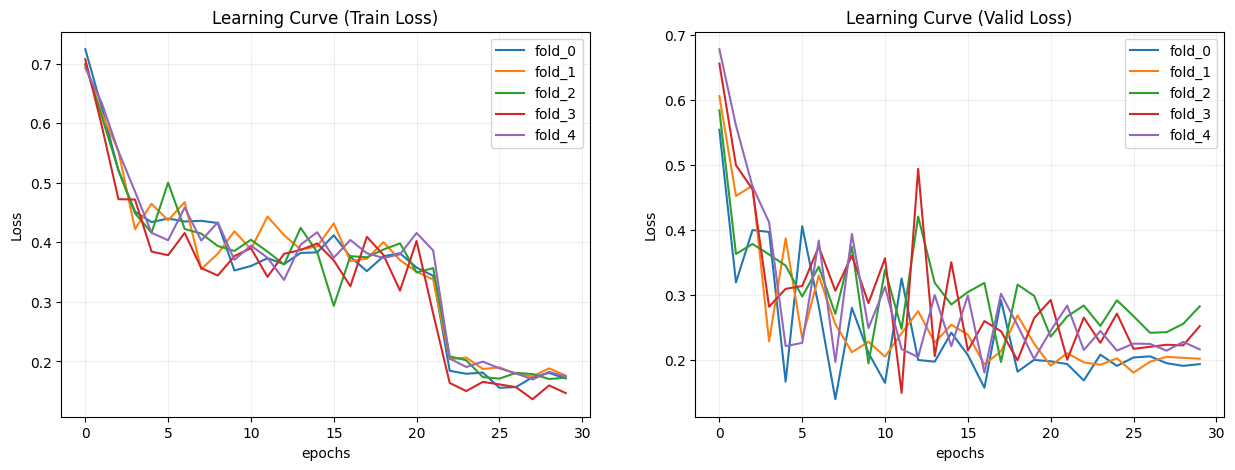

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1行2列のサブプロットを作成

for i, his in enumerate(list_history):
    axes[0].plot(his["Train Loss"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画
    axes[1].plot(his["Valid Loss"], label=f"fold_{i}")  # 2つ目のサブプロットにValid Lossを描画

axes[0].set_title("Learning Curve (Train Loss)")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("epochs")
axes[0].legend()
axes[0].grid(alpha=0.2)
# axes[0].set_ylim([0, 1])

axes[1].set_title("Learning Curve (Valid Loss)")
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("epochs")
axes[1].legend()
axes[1].grid(alpha=0.2)
# axes[1].set_ylim([0, 1])


# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# wandbに記録
# wandb.log({"learning_curve_loss": wandb.Image(img)})

plt.show()

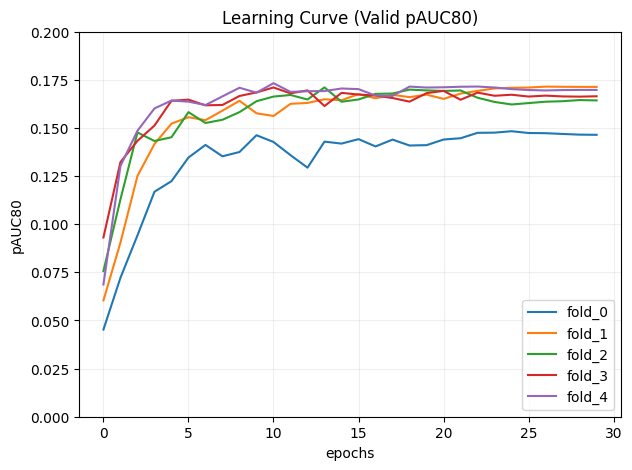

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))  # 1列のサブプロットを作成

for i, his in enumerate(list_history):
    ax.plot(his["Valid AUROC"], label=f"fold_{i}")  # Valid AUROCのみを描画

ax.set_title("Learning Curve (Valid pAUC80)")
ax.set_ylabel("pAUC80")
ax.set_xlabel("epochs")
ax.legend()
ax.grid(alpha=0.2)
ax.set_ylim([0, 0.2])

# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# # wandbに記録
# wandb.log({"learning_curve_pAUC80": wandb.Image(img)})

plt.show()

In [32]:
# data = [[x, y] for (x, y) in zip(range(len(his["Valid AUROC"].values)), his["Valid AUROC"].values)]
# table = wandb.Table(data=data, columns=["x", "y"])
# wandb.log(
#     {
#         "learning_curve_pAUC80": wandb.plot.line(
#             table, "x", "y", title="Learning Curve (Valid pAUC80)"
#         )
#     }
# )

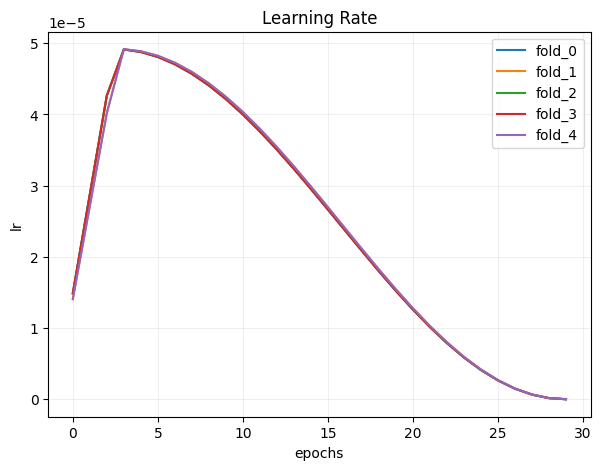

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(alpha=0.2)
for i, his in enumerate(list_history):
    ax.plot(his["lr"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画

ax.set_title("Learning Rate")
ax.set_ylabel("lr")
ax.set_xlabel("epochs")
ax.legend()

plt.show()

In [34]:
if CONFIG["save_preds"]:
    df_pred = pd.concat(list_preds)
    df_pred.to_csv(f"{CONFIG['save_dir']}/df_preds_{EXP_NAME}.csv", index=False)

In [35]:
pd.options.display.precision = 4

df_pauc = pd.DataFrame(columns=["pAUC80"])
for i, his in enumerate(list_history):
    df_pauc.loc[f"fold_{i}", "pAUC80"] = his["Valid AUROC"].values[-1]

df_pauc["pAUC80_notFiltered"] = list_score_notFiltered
df_pauc.loc["mean", "pAUC80_notFiltered"] = np.mean(df_pauc["pAUC80_notFiltered"])
df_pauc.loc["std", "pAUC80_notFiltered"] = np.std(df_pauc["pAUC80_notFiltered"])
df_pauc.loc["mean", "pAUC80"] = np.mean(df_pauc["pAUC80"])
df_pauc.loc["std", "pAUC80"] = np.std(df_pauc["pAUC80"])
df_pauc

,pAUC80,pAUC80_notFiltered
fold_0,0.1464,0.1475
fold_1,0.1713,0.1711
fold_2,0.1643,0.1640
fold_3,0.1665,0.1665
fold_4,0.1698,0.1664
mean,0.1637,0.1631
std,0.0082,0.0074


In [36]:
if WANDB:
    wandb.log({"pAUC80_fold0": df_pauc.loc["fold_0", "pAUC80"]})
    wandb.log({"pAUC80_fold1": df_pauc.loc["fold_1", "pAUC80"]})
    wandb.log({"pAUC80_fold2": df_pauc.loc["fold_2", "pAUC80"]})
    wandb.log({"pAUC80_fold3": df_pauc.loc["fold_3", "pAUC80"]})
    wandb.log({"pAUC80_fold4": df_pauc.loc["fold_4", "pAUC80"]})
    wandb.log({"pAUC80_mean": df_pauc.loc["mean", "pAUC80"]})

    wandb.finish()

pAUC80_fold0,▁
pAUC80_fold1,▁
pAUC80_fold2,▁
pAUC80_fold3,▁
pAUC80_fold4,▁
pAUC80_mean,▁
pAUC80_fold0,0.14644
pAUC80_fold1,0.17132
pAUC80_fold2,0.16432
pAUC80_fold3,0.16646
pAUC80_fold4,0.16976


In [37]:
# wandb.finish()